In [1]:
import ergo
from ergo.scale import Scale
import ergo.distributions as dist

import seaborn
import matplotlib.pyplot as plt

import jax.numpy as np

import os
from dotenv import load_dotenv

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/Users/nix/Dropbox/Projects/Ergo/ergo/ergo/ppl.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Two convience functions for debugging:

In [2]:
def graph(dist, bins=100):
    """Graph the pdf of some distribution"""
    xs = np.linspace(dist.ppf(0.01), dist.ppf(0.99), bins)
    ys = [dist.pdf(x) for x in xs]
    plt.plot(xs, ys)
    
def display_params(mixture):
    """Print a little summary of the composition of a logistic mixture.
    Not espeically robust, but good enough for here."""
    for i,c in enumerate(mixture.components):
        if hasattr(c, "base_dist"):
            c = c.base_dist
        print(f"Loc: {c.true_loc:3g} \t({c.loc:3g})",
              f"Scale: {c.true_s:3g} \t({c.s:3g})",
              f"Prob: {mixture.probs[i]:3g}",
             sep="\t")

In [3]:
# Load Metaculus data using ought credentials

def get_metaculus():
    load_dotenv()
    uname = str(os.getenv("METACULUS_USERNAME"))
    pwd = str(os.getenv("METACULUS_PASSWORD"))
    user_id_str = str(os.getenv("METACULUS_USER_ID"))
    if None in [uname, pwd, user_id_str]:
        raise ValueError(
            ".env is missing METACULUS_USERNAME, METACULUS_PASSWORD, or METACULUS_USER_ID"
        )
    user_id = int(user_id_str)
    metaculus = ergo.Metaculus(uname, pwd)
    assert metaculus.user_id == user_id
    return metaculus

# We use the "continious linear open question" from the test suite

metaculus = get_metaculus()
question = metaculus.get_question(3962)
print("Question Name: ", question.name)
print("Question Scale: ", question.scale)

Question Name:  Continuous, linear, open both ends (for testing)
Question Scale:  Scale(low=1.0, high=1000000.0, width=999999.0)


We make two test functions.  The first directly uses the LogisticMixture from_samples constructor.  The second uses the metaculus question's `get_submission_from_samples()` function, which:
1. normalizes the samples
2. calls the `from_samples` constructor
3. prepares the logistic mixture, including clipping and enforcing the scale to be (0,1)

In [4]:
def test_fit(lm):
    samples = np.array([lm.sample() for _ in range(0, 5000)])
    fit = dist.LogisticMixture.from_samples(samples, fixed_params={"num_components": 3},
                                        init_tries=200, opt_tries=3)
    
    graph(lm)
    graph(fit)
    
    plt.legend(["original ppf", "fit ppf"])
    
    print("original parameters:")
    display_params(lm)
    print("fit parameters:")
    display_params(fit)
    
    return fit
    
def test_question_fit(question, lm):
    assert lm.scale == question.scale
    
    samples = np.array([lm.sample() for _ in range(0, 5000)])
    fit = question.get_submission_from_samples(samples)
        
    normalized_lm = lm.normalize()
    
    graph(normalized_lm)
    graph(fit)
    
    plt.legend(["original ppf (normalized)", "fit ppf (normalized)"])
    
    print("original parameters:")
    display_params(normalized_lm)
    print("fit parameters:")
    display_params(fit)
    
    return fit

The fitting works well in most cases:

original parameters:
Loc: 400000 	(0.399999)	Scale: 100000 	(0.1)	Prob: 0.8
Loc: 700000 	(0.7)	Scale: 50000 	(0.05)	Prob: 0.2
fit parameters:
Loc: 706855 	(0.591213)	Scale: 27997.1 	(0.0100033)	Prob: 0.0631629
Loc: 668619 	(0.577551)	Scale: 72150.9 	(0.0257794)	Prob: 0.194002
Loc: 390855 	(0.478307)	Scale: 97840.6 	(0.0349583)	Prob: 0.742835


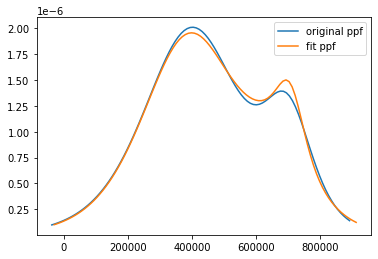

In [5]:
lm_1 = dist.LogisticMixture(
        components=[
            dist.Logistic(loc=400000, s=100000, scale=question.scale),
            dist.Logistic(loc=700000, s=50000, scale=question.scale),
        ],
        probs=[0.8, 0.2],
    )

test_fit(lm_1);

It fails in certain edge cases, however -- including when there are components with very narrow distributions.

original parameters:
Loc: 400000 	(0.399999)	Scale: 100000 	(0.1)	Prob: 0.8
Loc: 700000 	(0.7)	Scale: 5000 	(0.00500001)	Prob: 0.2
fit parameters:
Loc: 693609 	(0.567473)	Scale: 29286.7 	(0.01)	Prob: 0.141534
Loc: 381099 	(0.460766)	Scale: 96108 	(0.0328163)	Prob: 0.749165
Loc: 693607 	(0.567472)	Scale: 29286.7 	(0.01)	Prob: 0.109301


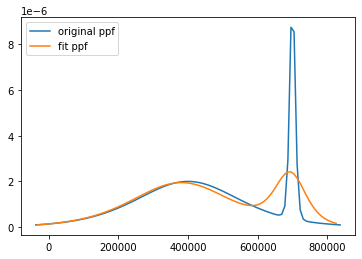

In [6]:
lm_2 = dist.LogisticMixture(
        components=[
            dist.Logistic(loc=400000, s=100000, scale=question.scale),
            dist.Logistic(loc=700000, s=5000, scale=question.scale),
        ],
        probs=[0.8, 0.2],
    )

test_fit(lm_2);

I believe the specific bug above is due to the fact that the `logistic_mixture.from_params()` method clips the scale between 0.01 and 0.5 (when normalized).  I'm not sure why this is, but it at least seems like something that should be documented or raise a warning instead of happening implicitly.

# Question Interface

original parameters:
Loc: 0.399999 	(0.399999)	Scale: 0.1 	(0.1)	Prob: 0.8
Loc: 0.7 	(0.7)	Scale: 0.05 	(0.05)	Prob: 0.2
fit parameters:
Loc: 0.391458 	(0.391458)	Scale: 0.0544172 	(0.0544172)	Prob: 0.0104234
Loc: 0.50847 	(0.50847)	Scale: 0.0387177 	(0.0387177)	Prob: 0.776313
Loc: 0.623199 	(0.623199)	Scale: 0.0187533 	(0.0187533)	Prob: 0.213263


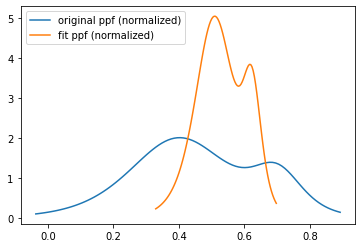

In [7]:
fit = test_question_fit(question, lm_1)

This clearly doesn't work as well -- seemingly because of a scale issue.  As an alternative way of checking, we can take samples from the new distribution and denormalize them to compare to the original distribution:

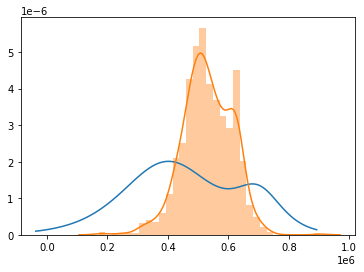

In [8]:
normalized_samples = np.array([fit.sample() for _ in range(1000)])
denormalized_samples = question.denormalize_samples(normalized_samples)

graph(lm_1)
seaborn.distplot(denormalized_samples)

I think this problem is due to the fact that `prepare_logistic` is passed distributions which aren't truely normalized, just made to fit normalized samples -- but then assumes that they are normalized anyway.